# Lecture: Edge Detector

## Section 1: Preparation

### Install the libraries

In [37]:
# Import the libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import pyrealsense2 as rs2
import cv2

from matplotlib import cm
from matplotlib.ticker import LinearLocator


### Capture an image using realsense camera

In [34]:
pipeline = rs2.pipeline()
config = rs2.config()

config.enable_stream(rs2.stream.color, 640, 480, rs2.format.bgr8, 30)
config.enable_stream(rs2.stream.depth, 640, 480, rs2.format.z16, 30)

pipeline.start(config)

# Display the livestream
while True:
    frame = pipeline.wait_for_frames()
    color_frame = frame.get_color_frame()

    color_image = np.asanyarray(color_frame.get_data())

    cv2.imshow("Captured Image", color_image)

    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('photo.jpg', color_image)

cv2.destroyAllWindows()

pipeline.stop()


## Section 2: Review: Sober Filter & Image gradient

### Display the captured image

The captured image


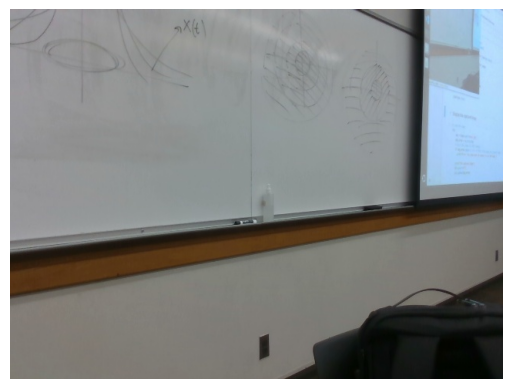

In [5]:
# Load the image
try:
    img = Image.open('photo.jpg')
    img_array = np.array(img)
    # Split the image into RGB channels
    if img_array.shape[-1] != 3: # Check if the image has 3 channels (RGB)
      print("Error: The image does not appear to be an RGB image.")

    print("The captured image")
    plt.axis("off")
    plt.imshow(img_array)


except FileNotFoundError:
    print("Error: The file photo.jpg was not found. Please make sure to capture an image first.")
except Exception as e:
    print(f"An error occurred: {e}")

### Define the image convolution

In [11]:
# Image convolution
def image_correlation(image_array, kernel):
    # Assume a gray-scale image
    assert len(image_array.shape) == 2, "Assume a grayscale image so far"
    H, W = image_array.shape
    kh, kw = kernel.shape
    
    # Correlation
    image_array_processed= np.zeros((H - kh + 1, W - kw + 1))
    for i in range(H - kh + 1):
        for j in range(W - kw + 1):
            image_array_processed[i, j] = np.sum(image_array[i:i+kh, j:j+kw] * kernel)
    return image_array_processed
def image_convolution(image_array, kernel):
    kernel_flipped = np.flip(kernel)
    return image_correlation(image_array, kernel_flipped)

### Define Gaussian kernel & Laplaican of Gaussian

In [12]:
# Create Laplacian of Gaussian
def create_laplacian_of_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = (-1/(np.pi*sigma**4)) * (1 - (xx**2 + yy**2)/(2*sigma*sigma)) * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel

def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / (2 * np.pi * sigma**2)

## Section 2: Keypoint Detection - Scale Space Extrema

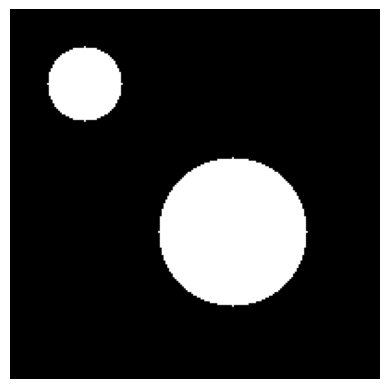

In [13]:
# Create a picture of a circle
def create_circle(grid, center, r):
    assert len(grid.shape) == 2, "Only support a plane"
    result = np.copy(grid)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if (i-center[0])**2 + (j-center[1])**2 <= r * r:
                result[i,j] = 1
    return result

grid = np.zeros((200, 200))
circle = create_circle(grid, [40, 40], 20)
circle_array = create_circle(circle, [120, 120], 40)
plt.imshow(circle_array, cmap="gray")
plt.axis("off")
plt.show()

### Apply Laplacian of Gaussian

Location with the largest scale response: [29, 30]
Value of the largest scale response: 0.3252667695624027


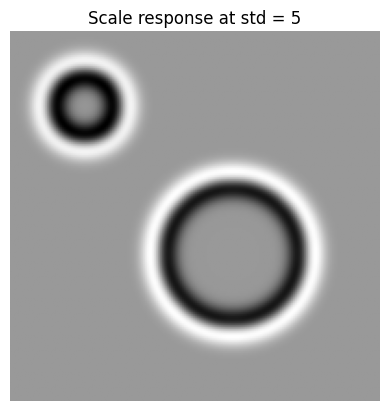

Location with the largest scale response: [40, 40]
Value of the largest scale response: 0.5411862762625576


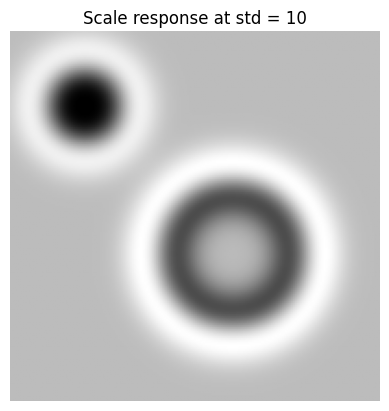

Location with the largest scale response: [40, 40]
Value of the largest scale response: 0.7308339407104483


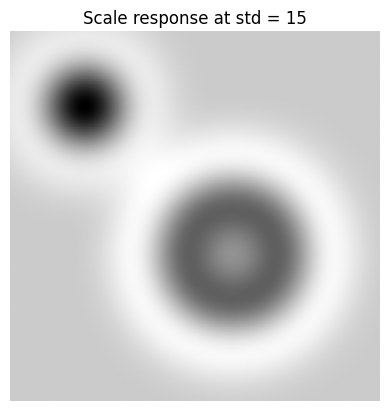

Location with the largest scale response: [40, 40]
Value of the largest scale response: 0.606582822603072


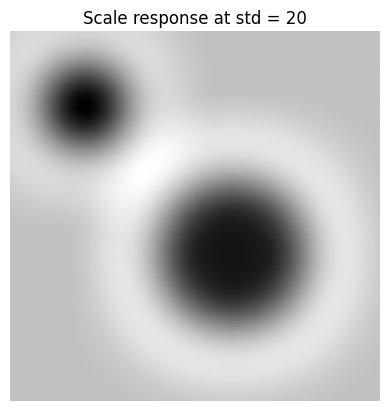

Location with the largest scale response: [120, 120]
Value of the largest scale response: 0.7118318855788014


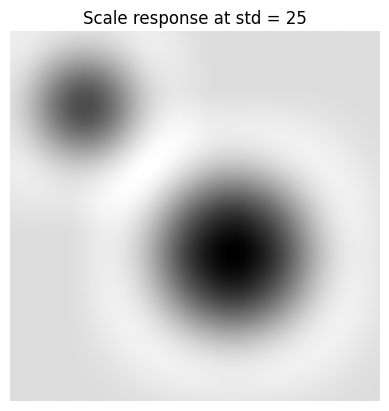

Location with the largest scale response: [120, 120]
Value of the largest scale response: 0.7356067200105989


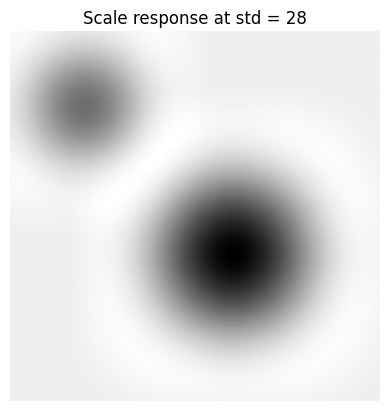

Location with the largest scale response: [120, 120]
Value of the largest scale response: 0.6064337309088319


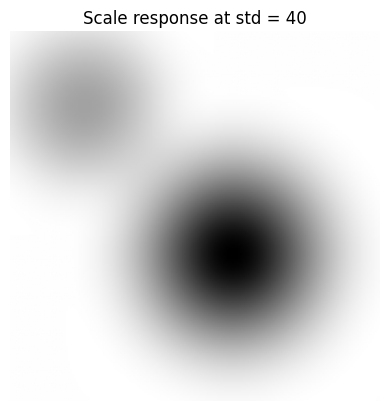

In [15]:
# Evaluation on different hyperparameters
for i in [5, 10, 15, 20, 25, 28, 40]:
    laplacian = i*i*create_laplacian_of_gaussian_kernel(101, i) # Normalization of the kernel
    circle_array_padding = np.pad(circle_array, pad_width=(int)((laplacian.shape[0]-1)/2), mode='constant', constant_values=0)
    circle_laplacian = image_convolution(circle_array_padding, laplacian)
    plt.imshow(circle_laplacian, cmap='gray')
    # Get the index of the maximum value in the flattened array
    flat_index = (np.abs(circle_laplacian)).argmax()
    
    # Convert the flattened index to 2D (row, column) indices
    row, col = np.unravel_index(flat_index, circle_laplacian.shape)
    response = np.max(np.abs(circle_laplacian))
    print("Location with the largest scale response: " + f"[{row}, {col}]")
    print("Value of the largest scale response: " + str(response))
    plt.axis("off")
    plt.title("Scale response at std = " + str(i))
    plt.show()

### Subpixel Keypoint Localization - Newton's method

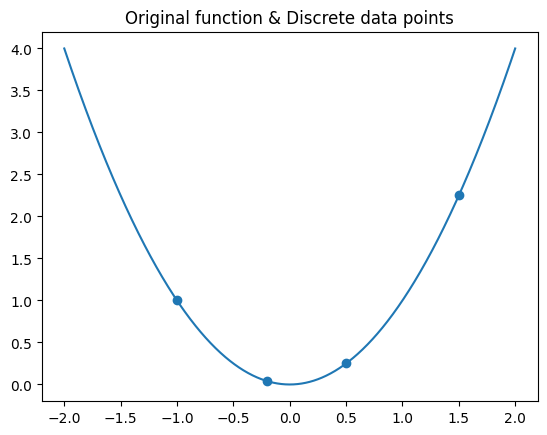

In [19]:
# Example in 1D
t = np.linspace(-2, 2, 1000)
f = t**2
t_discrete = np.array([-0.2, 0.5, -1, 1.5])
f_discrete = t_discrete ** 2
df = 2*t
ddf = 2
plt.plot(t, f)
plt.scatter(t_discrete, f_discrete)
plt.title("Original function & Discrete data points")
plt.show()


In [31]:
# Define the functions
def newton_method(x, f, df, ddf):
    dx = -(df(x))/(ddf(x))
    v1 = f(x)
    v2 = df(x)*dx
    v3 = (1/2)*ddf(x)*dx*dx
    v0 = x + dx

    return v0, v1 + v2 + v3
def square(x):
    return x**2
def square_d(x):
    return 2*x
def square_dd(x):
    return 2

x = t_discrete[np.argmin(f_discrete)]

x = newton_method(x, square, square_d, square_dd)
print("Result after Newton method: ")
print(x)

Result after Newton method: 
(np.float64(0.0), np.float64(0.0))


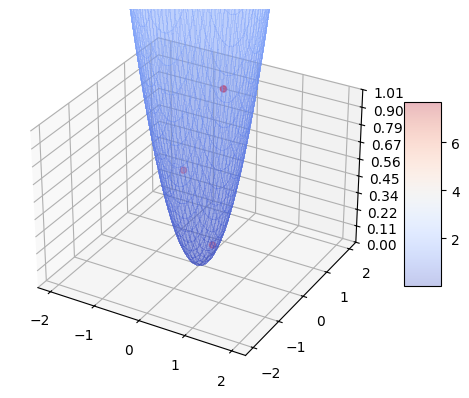

Newton method Demo: 
Grad: 
[ 0.8 -0.4]
Hessian: 
[[2 0]
 [0 2]]
Original data point: 
[ 0.4 -0.2]
First derivative term: 
-0.4000000000000001
Second derivative term: 
0.20000000000000004
[0. 0.]


In [51]:
# Example in 2D
def square_2d(x):
    return x[0]**2 + x[1]**2
def square_d_2d(x):
    return np.array([2*x[0], 2*x[1]])
def square_dd_2d(x):
    return np.array([
        [2, 0],
        [0, 2]
    ])

def newton_method(x, f, df, ddf):
    grad = df(x)
    hessian = ddf(x)
    dx = -np.linalg.inv(hessian)@grad
    v1 = f(x)
    v2 = np.dot(df(x), dx)
    v3 = (1/2)*(dx.T@hessian@dx)
    v0 = x + dx
    print("Newton method Demo: ")
    print("Grad: ")
    print(grad)
    print("Hessian: ")
    print(hessian)
    print("Original data point: ")
    print(x)
    print("First derivative term: ")
    print(v2)
    print("Second derivative term: ")
    print(v3)
    return v0, v1 + v2 + v3

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
t = np.linspace(-2, 2, 1000)
xx, yy = np.meshgrid(t, t)
f = xx**2 + yy**2
# Plot the surface.
surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.3)

# Plot the discrete data points
xs = np.array([0.4, -0.6, 0.9, 1])
ys = np.array([-0.2, 0.4, -0.7, -1.1])
zs = xs**2 + ys**2
ax.scatter(xs, ys, zs, color="red")
# Customize the z axis.
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

idx = np.argmin(zs)
x = np.array([xs[idx], ys[idx]])
x_new = newton_method(x, square_2d, square_d_2d, square_dd_2d)
print(x_new[0])

### Thresholding - Contrast
See the lecture slides

### Thresholding - Edge (Curvature)

Local extrema: 
[0 0]
Eigenvalues at local extrema: 
[2. 0.]


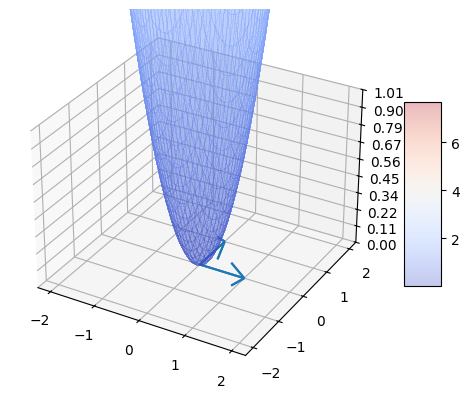

In [58]:
# Example in 2D


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
t = np.linspace(-2, 2, 1000)
xx, yy = np.meshgrid(t, t)


x = np.vstack((xx, yy)).T
g = xx**2


extrema = np.array([0, 0])
extrema_value = 0
hessian = np.array([
    [2, 0],
    [0, 0]
])
eig_values, eig_vectors = np.linalg.eig(hessian)
print("Local extrema: ")
print(extrema)
print("Eigenvalues at local extrema: ")
print(eig_values)

x_quiver = np.array([extrema[0], extrema[0]])
y_quiver = np.array([extrema[1], extrema[1]])
z_quiver = np.array([extrema_value, extrema_value])
u_quiver = np.array([eig_vectors[0], eig_vectors[0]]) 
v_quiver = np.array([eig_vectors[1], eig_vectors[1]])
w_quiver = np.array([0, 0]) #  Zero here to represent horizontal vectors
# Plot the surface.
surf = ax.plot_surface(xx, yy, f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.3)

ax.quiver(x_quiver, y_quiver, z_quiver, u_quiver, v_quiver, w_quiver)
# Customize the z axis.
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Local extrema: 
[0 0]
Eigenvalues at local extrema: 
[2. 0.]
Eigenvectors at local extrema: 
[[1. 0.]
 [0. 1.]]


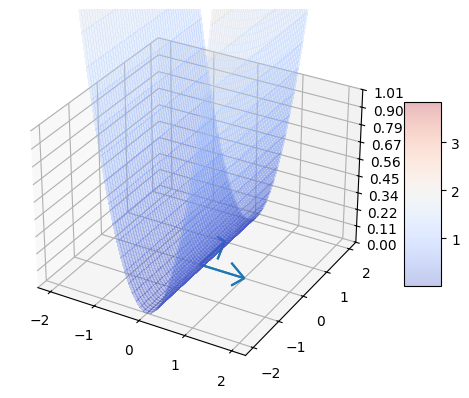

In [63]:
# Example in 2D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
t = np.linspace(-2, 2, 1000)
xx, yy = np.meshgrid(t, t)


x = np.vstack((xx, yy)).T
g = xx**2



extrema = np.array([0, 0])
extrema_value = 0
hessian = np.array([
    [2, 0],
    [0, 0]
])
eig_values, eig_vectors = np.linalg.eig(hessian)
print("Local extrema: ")
print(extrema)
print("Eigenvalues at local extrema: ")
print(eig_values)
print("Eigenvectors at local extrema: ")
print(eig_vectors)

x_quiver = np.array([extrema[0], extrema[0]])
y_quiver = np.array([extrema[1], extrema[1]])
z_quiver = np.array([extrema_value, extrema_value])
u_quiver = np.array([eig_vectors[0], eig_vectors[0]]) 
v_quiver = np.array([eig_vectors[1], eig_vectors[1]])
w_quiver = np.array([0, 0]) #  Zero here to represent horizontal vectors
# Plot the surface.
surf = ax.plot_surface(xx, yy, g, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.3)

ax.quiver(x_quiver, y_quiver, z_quiver, u_quiver, v_quiver, w_quiver)
# Customize the z axis.
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Section 3: Orientation Assignment
See the lecture slides & solutions to the first project

## Section 4: SIFT from OpenCV
Reference: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

In [67]:
img = cv2.imread('photo.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # In OpenCV, the image is represented in the format (blue, green, red)

sift = cv2.SIFT_create()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp,img)

cv2.imshow("Sift features extracted from the image", img)
cv2.waitKey(0)

-1

In [69]:
img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("Sift features (with orientation) extracted from the image", img)
cv2.waitKey(0)

-1